<a href="https://colab.research.google.com/github/sankajithdjinasena/BrainTumorDetection/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import Dataset and review**

In [5]:
def create_image_dataframe(base_path):
    data = []

    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                data.append({
                    "Image_Path": os.path.join(label_path, image),
                    "Image_Class": label
                })

    return pd.DataFrame(data)

In [6]:
train_df = create_image_dataframe('/content/drive/MyDrive/BioFusion/data/Training')
test_df = create_image_dataframe('/content/drive/MyDrive/BioFusion/data/Testing')

In [7]:
train_df.head()

,Image_Path,Image_Class
0,/content/drive/MyDrive/BioFusion/data/Training...,meningioma
1,/content/drive/MyDrive/BioFusion/data/Training...,meningioma
2,/content/drive/MyDrive/BioFusion/data/Training...,meningioma
3,/content/drive/MyDrive/BioFusion/data/Training...,meningioma
4,/content/drive/MyDrive/BioFusion/data/Training...,meningioma


In [8]:
test_df.head()

,Image_Path,Image_Class
0,/content/drive/MyDrive/BioFusion/data/Testing/...,glioma
1,/content/drive/MyDrive/BioFusion/data/Testing/...,glioma
2,/content/drive/MyDrive/BioFusion/data/Testing/...,glioma
3,/content/drive/MyDrive/BioFusion/data/Testing/...,glioma
4,/content/drive/MyDrive/BioFusion/data/Testing/...,glioma


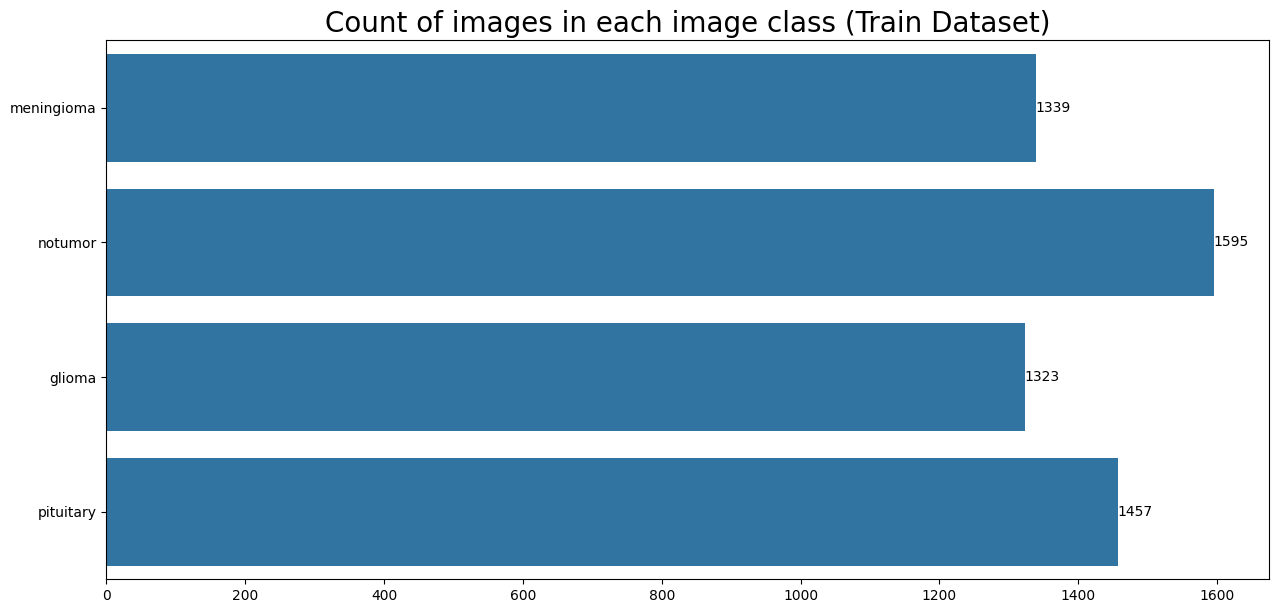

In [9]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Image_Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each image class (Train Dataset)', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

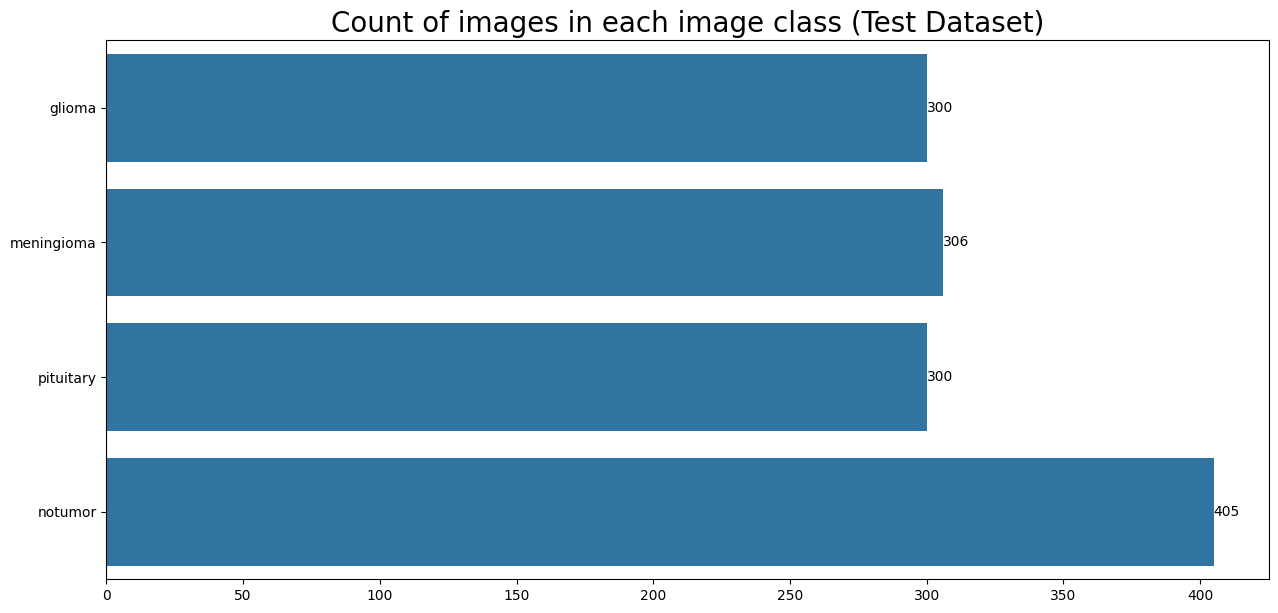

In [10]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=test_df , y=test_df['Image_Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each image class (Test Dataset)', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [11]:
valid_df, ts_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Image_Class'])

In [12]:
valid_df.shape, ts_df.shape

((655, 2), (656, 2))

In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(train_df, x_col='Image_Path',
                                  y_col='Image_Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Image_Path',
                                     y_col='Image_Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Image_Path',
                                  y_col='Image_Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5714 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


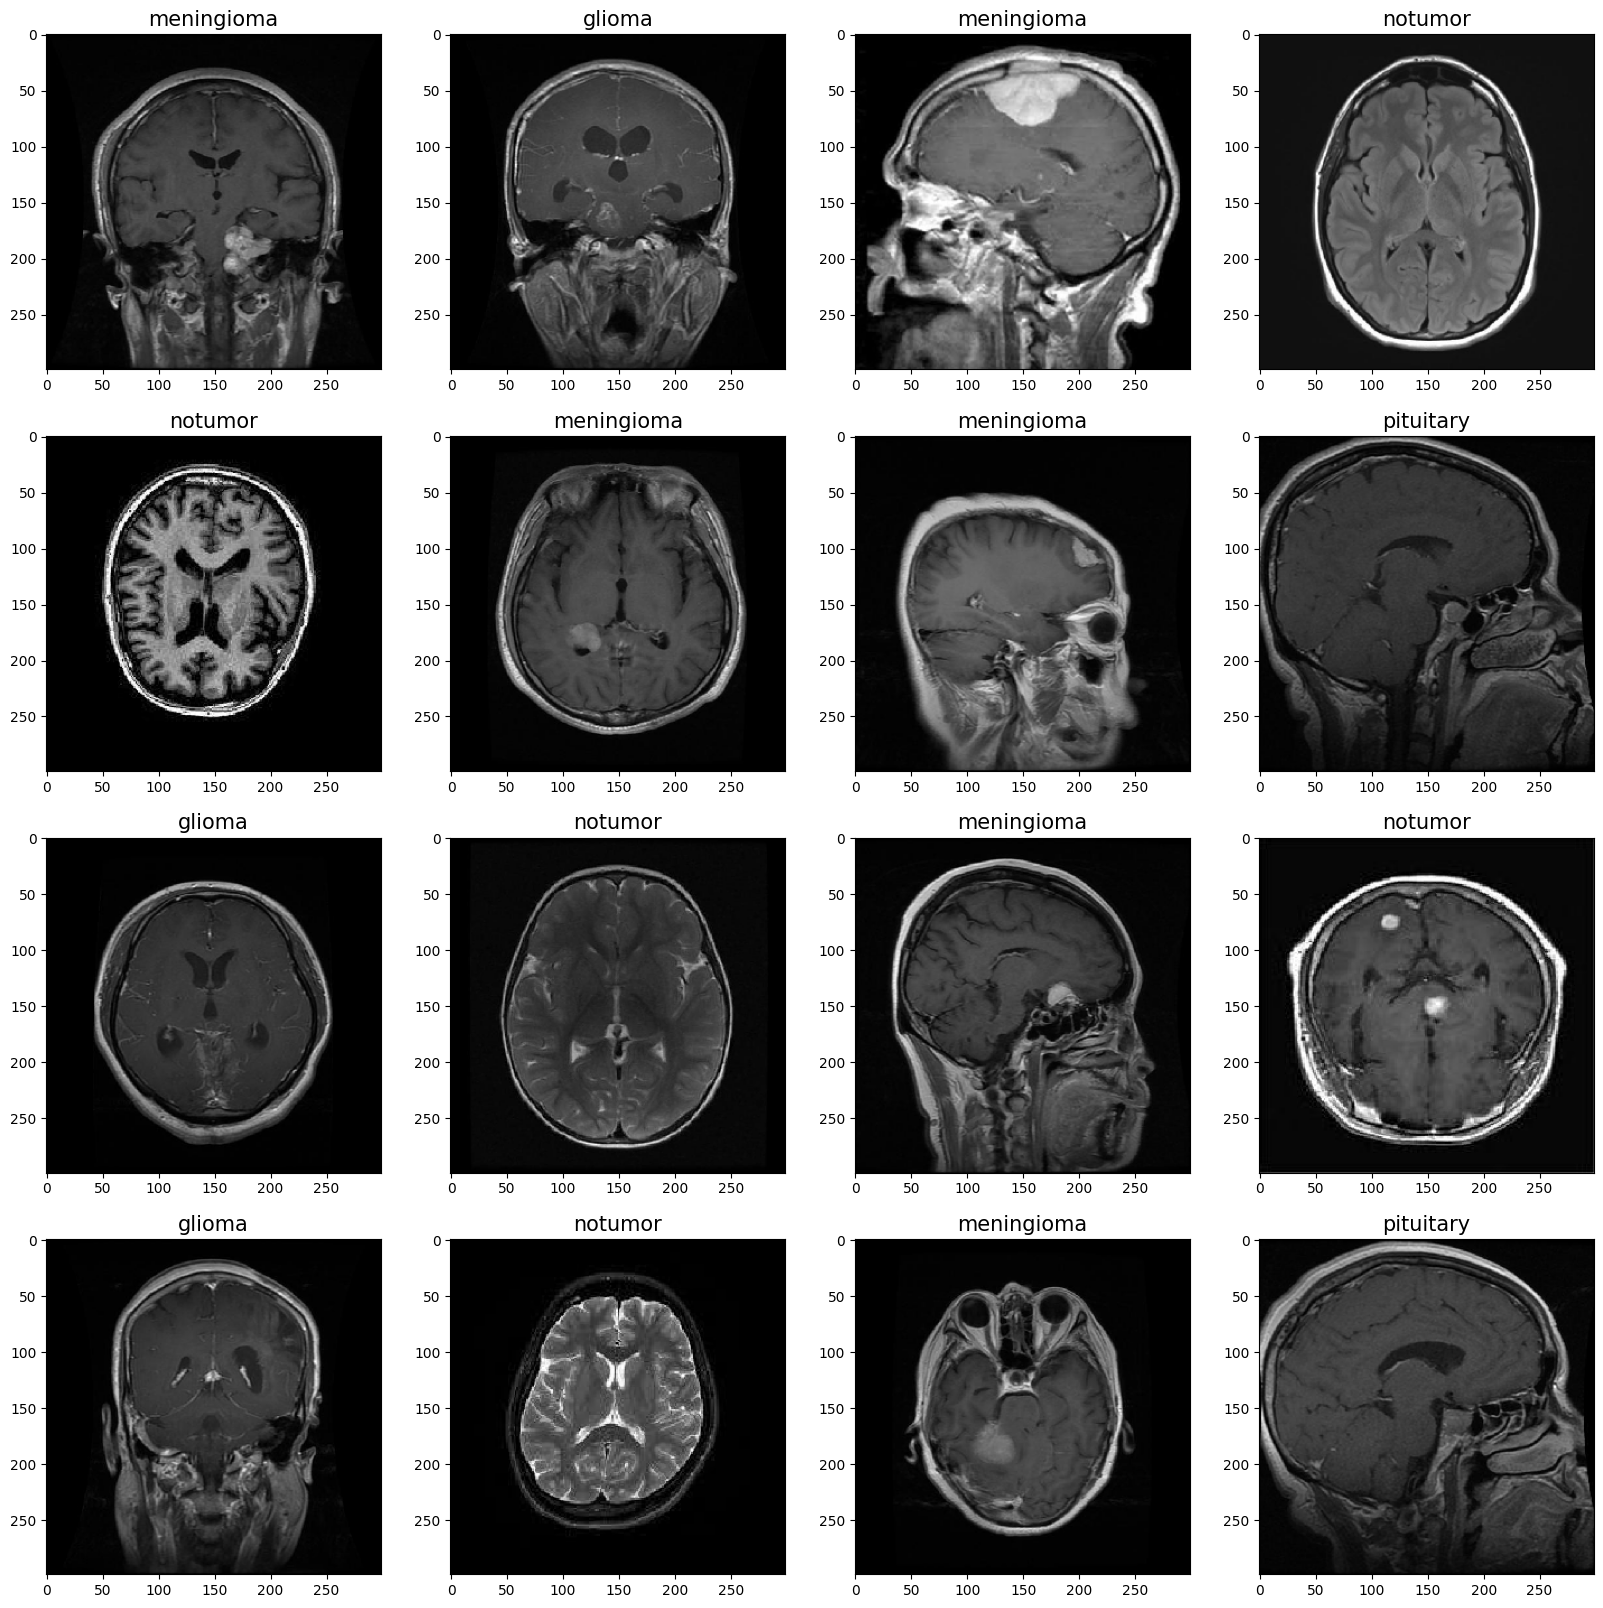

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [15]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

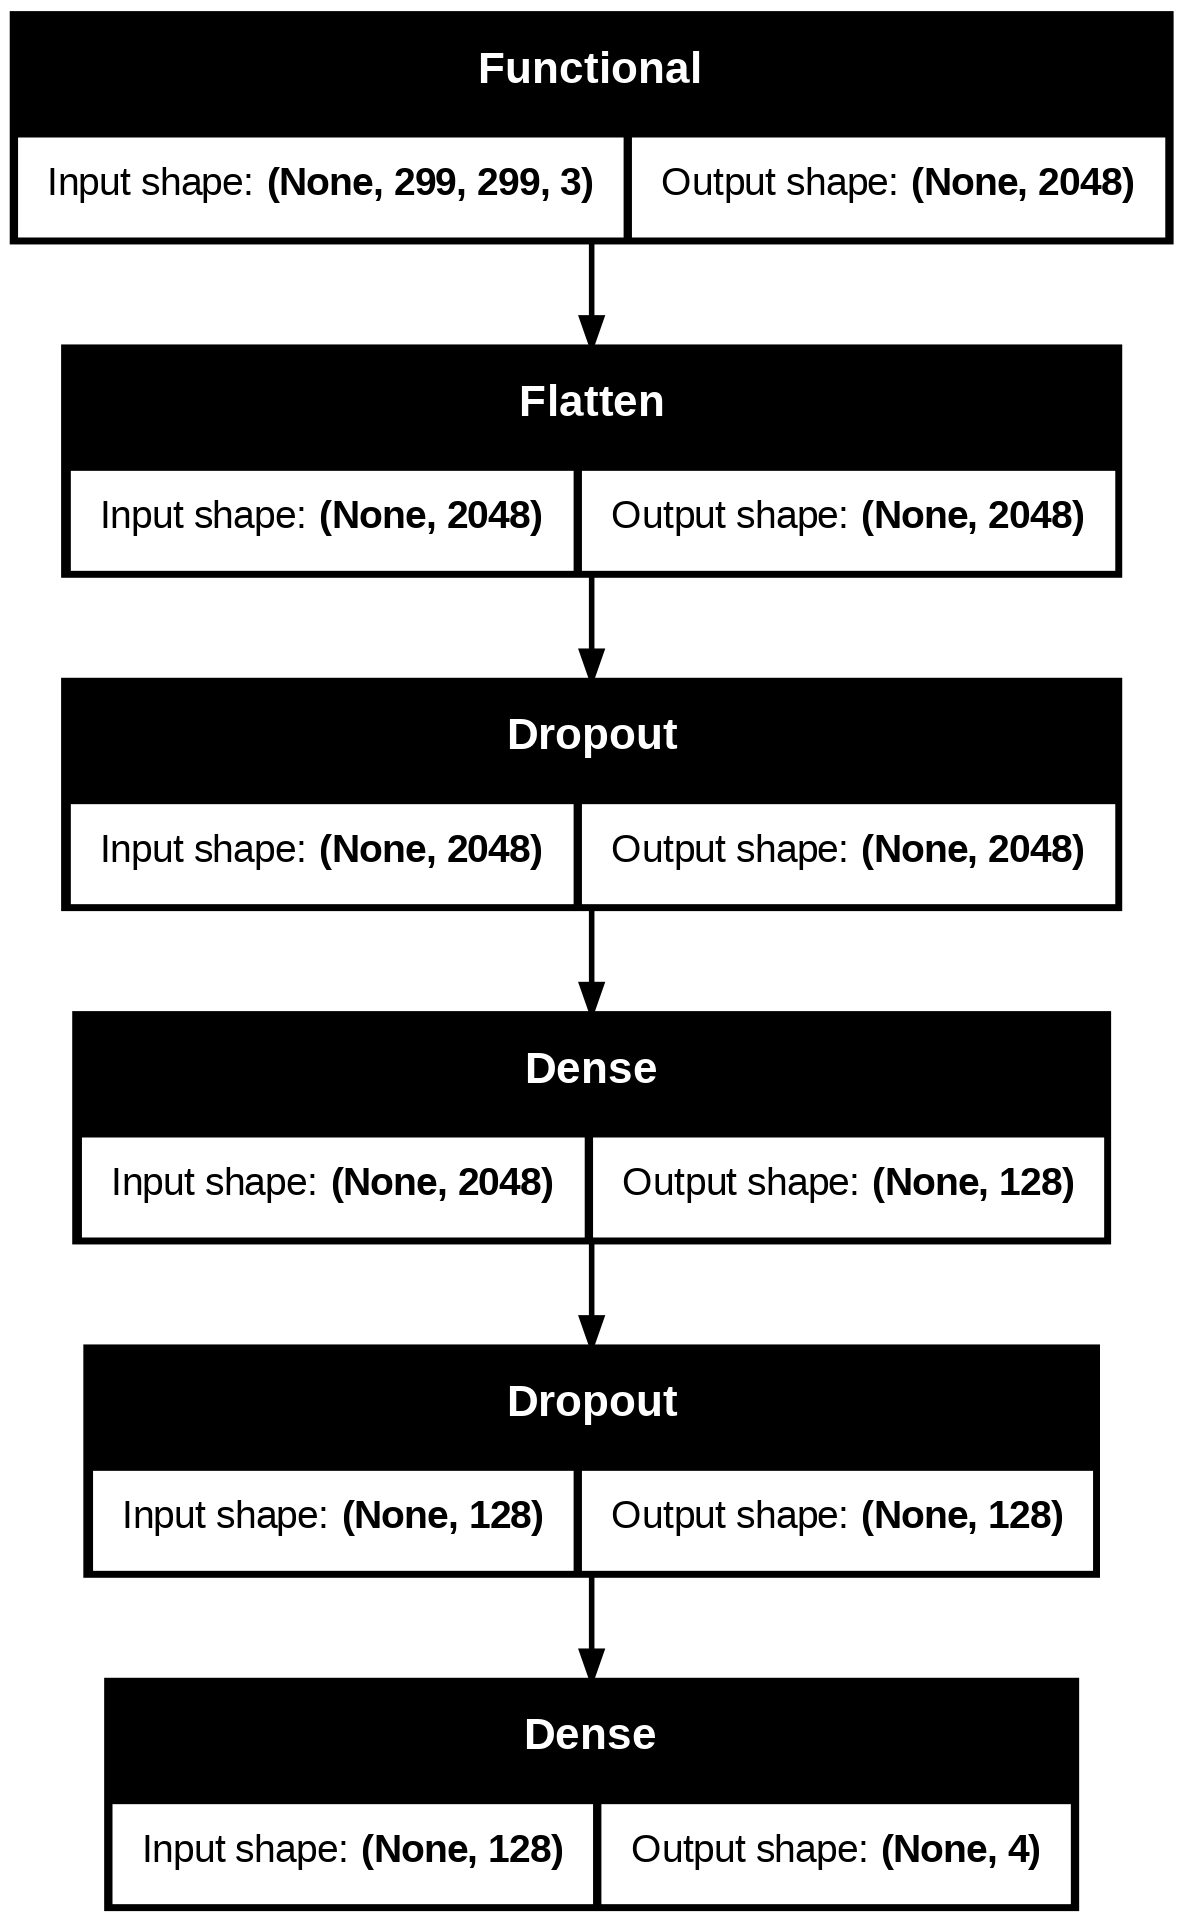

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2146s 11s/step - accuracy: 0.7619 - loss: 0.6589 - precision: 0.8381 - recall: 0.6636 - val_accuracy: 0.9374 - val_loss: 0.1806 - val_precision: 0.9543 - val_recall: 0.9237
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 844ms/step - accuracy: 0.9820 - loss: 0.0619 - precision: 0.9843 - recall: 0.9786 - val_accuracy: 0.9603 - val_loss: 0.1206 - val_precision: 0.9602 - val_recall: 0.9588
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 848ms/step - accuracy: 0.9918 - loss: 0.0265 - precision: 0.9923 - recall: 0.9901 - val_accuracy: 0.9771 - val_loss: 0.0549 - val_precision: 0.9786 - val_recall: 0.9771
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 842ms/step - accuracy: 0.9951 - loss: 0.0157 - precision: 0.9958 - recall: 0.9951 - val_accuracy: 0.9924 - val_loss: 0.0324 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 845ms/step - accuracy: 0.9982 - loss: 0.0064 - precision: 0.9982 - recall: 0.9982 - val_accuracy: 0.

In [18]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [19]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 58s 324ms/step - accuracy: 0.9982 - loss: 0.0048 - precision: 0.9982 - recall: 0.9982
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.9858 - loss: 0.0833 - precision: 0.9858 - recall: 0.9858
41/41 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.9918 - loss: 0.0350 - precision: 0.9918 - recall: 0.9918
Train Loss: 0.0054
Train Accuracy: 99.79%
--------------------
Validation Loss: 0.0878
Validation Accuracy: 98.32%
--------------------
Test Loss: 0.0739
Test Accuracy: 98.78%


In [27]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step


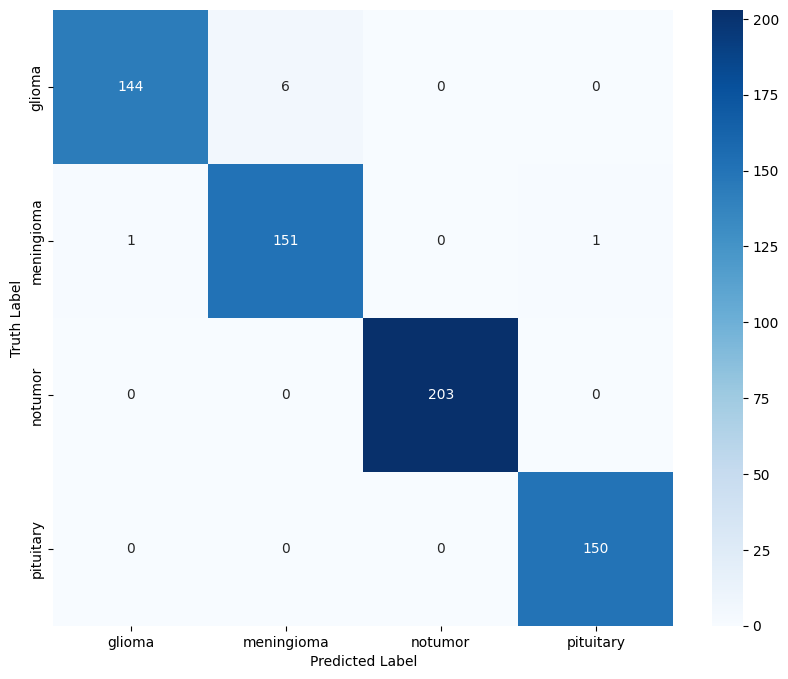

In [28]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [22]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       150
           1       0.96      0.99      0.97       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


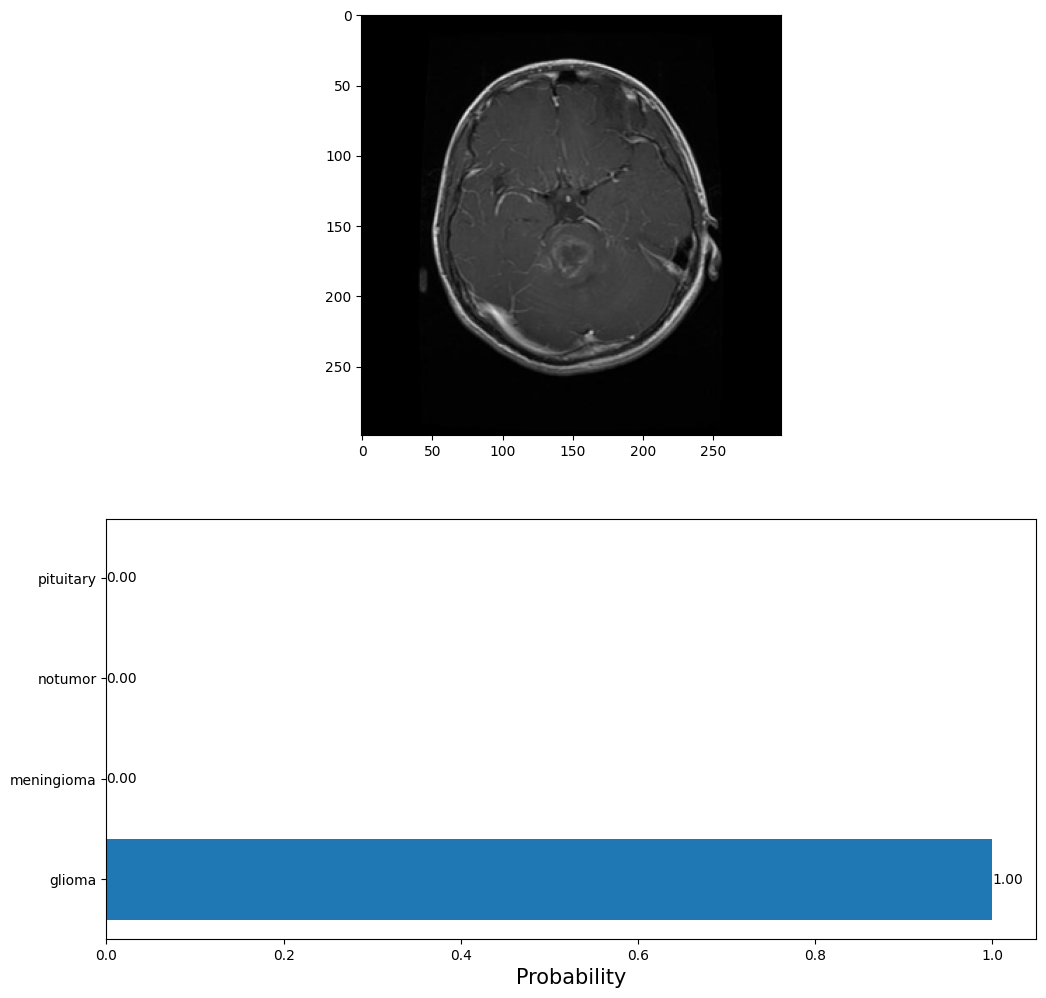

In [25]:
predict('/content/drive/MyDrive/BioFusion/data/Testing/glioma/Te-glTr_0007.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


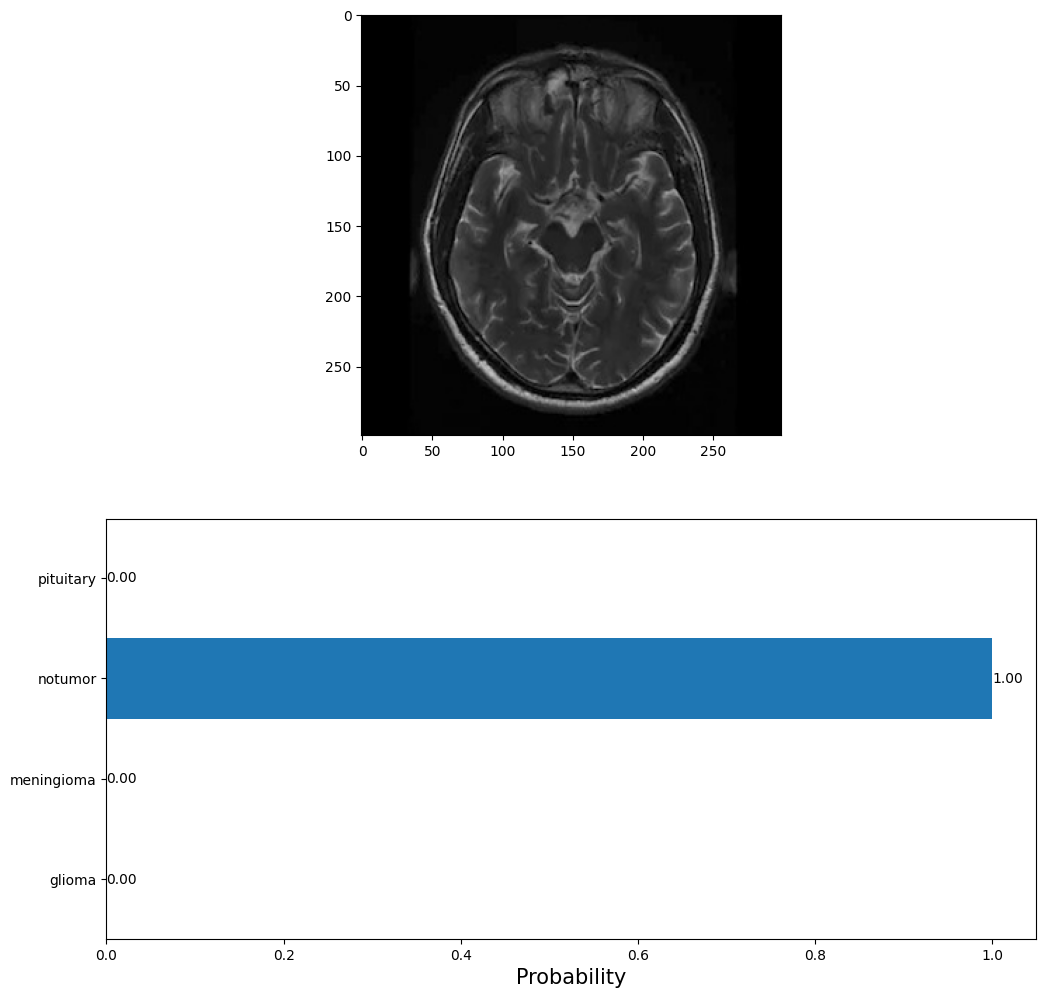

In [26]:
predict('/content/drive/MyDrive/BioFusion/data/Testing/notumor/Te-noTr_0006.jpg')
